<a href="https://colab.research.google.com/github/LilDataScientist/Covid-Lung-CT-Image-Segmentation/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-8o_mbwlx
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-8o_mbwlx


In [2]:
import segmentation_models_pytorch as smp

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import dependencies

In [4]:
import torch
import json
import os
import torchvision
import csv

import torch.nn.functional as F
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.notebook import tqdm
from PIL import Image
from torch import nn

In [5]:
device = torch.device('cuda:0')

In [6]:
PROJECT_PATH = '/content/drive/MyDrive/Covid Lung CT Image Segmentation'

# Dataset class

Since each observation consists of many (30-50) layers we are goind to parse it as a single image.  
So insted of having (n, k, 512, 512) we will have (n * k, 512, 512)

In [7]:
import random

def AugmentFlip(X, y):
    return torchvision.transforms.functional.vflip(X), torchvision.transforms.functional.vflip(y)

def AugmentRotate(X, y):
    degs = [-20, 20, -15, 15, -10, 10, -5, 5]
    deg = random.choice(degs)
    return torchvision.transforms.functional.rotate(X, deg), torchvision.transforms.functional.rotate(y, deg)

In [8]:
class CovidDataset(Dataset):
    def __init__(self, path_to_data, path_to_json):
        self.path_to_data = path_to_data
        self.path_to_json = path_to_json
        
        path_images = os.path.join(path_to_data, 'images')
        path_labels = os.path.join(path_to_data, 'labels')
        
        with open(path_to_json, 'r') as f:
            dict_training = json.load(f)
            
        self.x = torch.Tensor()
        self.y = torch.Tensor()
        
        for entry in tqdm(dict_training):
            image = nib.load(os.path.join(path_images, entry['image'][:-3])).get_fdata()
            label = nib.load(os.path.join(path_labels, entry['label'][:-3])).get_fdata()
            
            image = image.swapaxes(0, 2).swapaxes(1, 2).reshape(-1, 1, 512, 512)
            label = label.swapaxes(0, 2).swapaxes(1, 2).reshape(-1, 1, 512, 512)
            
            image = torch.tensor(image)
            label = torch.tensor(label)
                
            if self.x.numel() == 0:
                self.x = image
                self.y = label
            else:
                self.x = torch.cat((self.x, image), dim=0)
                self.y = torch.cat((self.y, label), dim=0)
                
            
            if random.random() > 0.5:
                image, label = AugmentFlip(image, label)
                self.x = torch.cat((self.x, image), dim=0)
                self.y = torch.cat((self.y, label), dim=0)

            if random.random() > 0.5:
                image, label = AugmentRotate(image, label)
                self.x = torch.cat((self.x, image), dim=0)
                self.y = torch.cat((self.y, label), dim=0)
                
        self.x = self.x.float()
        self.y = self.y.float()
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Load training dataset

In [9]:
dataset = CovidDataset(path_to_data=f'{PROJECT_PATH}/data', 
                          path_to_json=f'{PROJECT_PATH}/training_data.json')

  0%|          | 0/40 [00:00<?, ?it/s]

In [10]:
samples = dataset.x.shape[0] # 1651 with no augumentations 

val_samples = samples // 100 * 10
training_samples = samples - val_samples

print(f'{samples} samples. {training_samples} Training samples. {val_samples} Validations samples')

3002 samples. 2702 Training samples. 300 Validations samples


In [11]:
train_set, val_set = torch.utils.data.random_split(dataset, [training_samples, val_samples])


train_loader = DataLoader(train_set, shuffle=True, batch_size=16)
val_loader = DataLoader(val_set, shuffle=True, batch_size=16)

In [12]:
def blend(image, mask):
    image = image.detach().cpu().numpy()
    mask = mask.detach().cpu().numpy()
    
    image = image.astype(np.float32)
    min_in = image.min()
    max_in = image.max()
    image = (image - min_in) / (max_in - min_in + 1e-8) * 255
    image = np.dstack((image, image, image)).astype(np.uint8)
    zeros = np.zeros_like(mask)
    mask = np.dstack((zeros, zeros, mask * 255)).astype(np.uint8)
    return Image.blend(
        Image.fromarray(image),
        Image.fromarray(mask),
        alpha=.2
    )

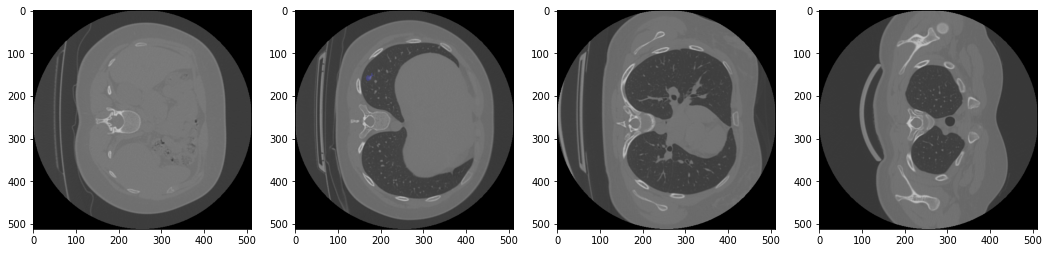

In [13]:
samples = [0, 10, 20, 30]

slices = [blend(dataset.x[sample, 0], dataset.y[sample, 0]) for sample in samples]
    
figure = plt.figure(figsize=(18, 18))
for i, image in enumerate(slices):
    ax = figure.add_subplot(1, len(slices), i + 1)
    ax.imshow(slices[i])

# Train Model

In [14]:
# class conv_block(nn.Module):
#     def __init__(self, in_c, out_c):
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(out_c)
#         self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
#         self.bn2 = nn.BatchNorm2d(out_c)
#         self.relu = nn.ReLU()
#     def forward(self, inputs):
#         x = self.conv1(inputs)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.relu(x)
#         return x

# class encoder_block(nn.Module):
#     def __init__(self, in_c, out_c):
#         super().__init__()
#         self.conv = conv_block(in_c, out_c)
#         self.pool = nn.MaxPool2d((2, 2))
#     def forward(self, inputs):
#         x = self.conv(inputs)
#         p = self.pool(x)
#         return x, p
    
# class decoder_block(nn.Module):
#     def __init__(self, in_c, out_c):
#         super().__init__()
#         self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
#         self.conv = conv_block(out_c+out_c, out_c)
#     def forward(self, inputs, skip):
#         x = self.up(inputs)
#         x = torch.cat([x, skip], axis=1)
#         x = self.conv(x)
#         return x
    
# class UNet(nn.Module):
#     def __init__(self):
#         super().__init__()
        
#         """ Encoder """
#         self.e1 = encoder_block(1, 64)
#         self.e2 = encoder_block(64, 128)
#         self.e3 = encoder_block(128, 256)
#         self.e4 = encoder_block(256, 512)
        
#         """ Bottleneck """
#         self.b = conv_block(512, 1024)
        
#         """ Decoder """
#         self.d1 = decoder_block(1024, 512)
#         self.d2 = decoder_block(512, 256)
#         self.d3 = decoder_block(256, 128)
#         self.d4 = decoder_block(128, 64)
#         """ Classifier """
#         self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)
#     def forward(self, inputs):
#         """ Encoder """
#         s1, p1 = self.e1(inputs)
#         s2, p2 = self.e2(p1)
#         s3, p3 = self.e3(p2)
#         s4, p4 = self.e4(p3)
        
#         """ Bottleneck """
#         b = self.b(p4)
        
#         """ Decoder """
#         d1 = self.d1(b, s4)
#         d2 = self.d2(d1, s3)
#         d3 = self.d3(d2, s2)
#         d4 = self.d4(d3, s1)
#         """ Classifier """
            
#         outputs = self.outputs(d4)
        
#         outputs = torch.sigmoid(outputs)
        
#         return outputs

In [15]:
class DiceLoss(nn.Module):
    def __init__(self, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [16]:
class TverskyLoss(nn.Module):
    def __init__(self):
        super(TverskyLoss, self).__init__()
        self.alpha = 0.3

    def forward(self, inputs, targets, smooth=1):
        y_pred = inputs
        y_true = targets
        y_true_pos = y_true.view(-1)
        y_pred_pos = y_pred.view(-1)
        true_pos = torch.sum(y_true_pos * y_pred_pos)
        false_neg = torch.sum(y_true_pos * (1 - y_pred_pos))
        false_pos = torch.sum((1 - y_true_pos) * y_pred_pos)
        return 1 - (true_pos + smooth) / (true_pos + self.alpha * false_neg + (1 - self.alpha) * false_pos + smooth)

In [17]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() >= 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1):
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return [str(item) for item in run_lengths]

In [18]:
# unet = UNet()

# model_save_name = 'unet__dice_train_loss:0.5825382060818858__dice_val_loss:0.5599653457486352                         __tversky_train_loss:0.6219106465191037__tversky_val_loss:0.6030637164448582.pt'
# path = f"{PROJECT_PATH}/Models/{model_save_name}"
# unet.load_state_dict(torch.load(path))

# unet.to(device)

# optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)

# criterion_dice_loss =  DiceLoss()
# criterion_tversky_loss = TverskyLoss()

In [21]:
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation='sigmoid',
    in_channels = 1,
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.005)

criterion_dice_loss =  DiceLoss()
criterion_tversky_loss = TverskyLoss()

In [ ]:
EPOCHS = 100
EVAL_EVERY = 1

for epoch in tqdm(range(EPOCHS)):
    """Train"""
    model.train()
    for x, y in tqdm(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion_tversky_loss(output, y)
        loss.backward()
        optimizer.step()
        del output, loss, x, y
        torch.cuda.empty_cache()
    
    """Evaluate"""
    if (epoch + 1) % EVAL_EVERY == 0:
        model.eval()
        print()
        print(f'Epoch: {epoch + 1}')

        """Validation"""
        val_tversky_loss_hist = []
        val_dice_loss_hist = []
        with torch.no_grad():
            for x, y in tqdm(val_loader):
                x, y, = x.to(device), y.to(device)
                output = model(x)
                val_tversky_loss_hist.append(criterion_tversky_loss(output, y).item())
                val_dice_loss_hist.append(criterion_dice_loss(output, y).item())
                del x, y
                torch.cuda.empty_cache()

        val_tversky_loss = sum(val_tversky_loss_hist) / len(val_tversky_loss_hist)
        val_dice_loss = sum(val_dice_loss_hist) / len(val_dice_loss_hist)
        print(f'val_tversky_loss_hist: {val_tversky_loss}')
        print(f'val_dice_loss_hist: {val_dice_loss}')
            
            
        """Train"""
        train_tversky_loss_hist = []
        train_dice_loss_hist = []
        with torch.no_grad():
            for x, y in tqdm(train_loader):
                x, y, = x.to(device), y.to(device)
                output = model(x)
                train_tversky_loss_hist.append(criterion_tversky_loss(output, y).item())
                train_dice_loss_hist.append(criterion_dice_loss(output, y).item())
                del x, y
                torch.cuda.empty_cache()     

        train_tversky_loss = sum(train_tversky_loss_hist) / len(train_tversky_loss_hist)
        train_dice_loss = sum(train_dice_loss_hist) / len(train_dice_loss_hist)
        print(f'train_tversky_loss_hist: {train_tversky_loss}')
        print(f'train_dice_loss_hist: {train_dice_loss}')
        print()

        """Save model"""
        model_save_name = f'dice_train_loss:{train_dice_loss}__dice_val_loss:{val_dice_loss} \
                        __tversky_train_loss:{train_tversky_loss}__tversky_val_loss:{val_tversky_loss}.pt'

        path = f"{PROJECT_PATH}/Models/{model_save_name}" 
        torch.save(model.state_dict(), path)

        with open(f'{PROJECT_PATH}/testing_data.json', 'r') as f:
            dict_testing = json.load(f)

        output = []
        for entry in tqdm(dict_testing):
            image = nib.load(os.path.join(f'{PROJECT_PATH}/data/images', entry['image'][:-3]))
            image = image.get_fdata().swapaxes(0, 2).swapaxes(1, 2).reshape(-1, 1, 512, 512)
            tmp = None
            for i in range(image.shape[0]):
                
                img = image[i:i+1]
                img = torch.tensor(img).to(device).float()
                img = model(img).cpu().detach().numpy()[0]

                tmp = img if tmp is None else np.vstack([tmp, img])

            tmp = tmp.swapaxes(0, 1).swapaxes(1, 2)
            output.append(tmp)

        with open(f'submission{epoch+1}.csv', "wt") as sb:
            submission_writer = csv.writer(sb, delimiter=',')
            submission_writer.writerow(["Id", "Predicted"])
            for k_i, patient_i in tqdm(zip(dict_testing, output)):
                submission_writer.writerow([
                        f"{k_i['image'][:-7]}",
                        " ".join(rle_encoding(patient_i))
                    ])

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]


Epoch: 1


  0%|          | 0/19 [00:00<?, ?it/s]

val_tversky_loss_hist: 0.9934963521204496
val_dice_loss_hist: 0.9910563167772795


  0%|          | 0/169 [00:00<?, ?it/s]

train_tversky_loss_hist: 0.9947488875784112
train_dice_loss_hist: 0.9927578776545779



  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

In [ ]:
unet.eval()
tmp_x = dataset.x[0].reshape(1, 1, 512, 512).to(device)
tmp_y = unet(tmp_x)
plt.imshow(tmp_y.detach().cpu().numpy().reshape(512, 512))

del tmp_x, tmp_y

In [ ]:
with open(f'{PROJECT_PATH}/testing_data.json', 'r') as f:
            dict_testing = json.load(f)

output = []
for entry in tqdm(dict_testing):
    image = nib.load(os.path.join(f'{PROJECT_PATH}/data/images', entry['image'][:-3]))
    image = image.get_fdata().swapaxes(0, 2).swapaxes(1, 2).reshape(-1, 1, 512, 512)
    tmp = None
    for i in range(image.shape[0]):
                
        img = image[i:i+1]
        img = torch.tensor(img).to(device).float()
        img = unet(img).cpu().detach().numpy()[0]

        tmp = img if tmp is None else np.vstack([tmp, img])

    tmp = tmp.swapaxes(0, 1).swapaxes(1, 2)
    output.append(tmp)

with open(f'submission.csv', "wt") as sb:
    submission_writer = csv.writer(sb, delimiter=',')
    submission_writer.writerow(["Id", "Predicted"])
    for k_i, patient_i in tqdm(zip(dict_testing, output)):
        submission_writer.writerow([
                f"{k_i['image'][:-7]}",
                " ".join(rle_encoding(patient_i))
            ])